In [1]:
# this is a very simple model:
# first i estimate # of michelin restaurants that DC will have
# then i combine several top restaurant lists (zagat, washingtonian, tom sietsema)
# and augment with yelp stats (cost, percent of 5 star reviews, etc)
# finally i do some rule-based filtering & sum metric z-scores into a final score

In [2]:
%matplotlib inline

import json
import requests
from time import sleep
from urllib.parse import quote

from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

In [3]:
# first, let's look at other cities w/ michelin data
# (data from wikipedia)

cols = ['city', 'year', 'mich_places', '1s', '2s', '3s']
info = [
    ('sf', 2014, 38, 29, 7, 2),
    ('sf', 2015, 40, 30, 6, 4),
    ('sf', 2016, 50, 38, 7, 5),
    ('chicago', 2014, 25, 20, 4, 1),
    ('chicago', 2015, 24, 19, 3, 2),
    ('chicago', 2016, 22, 17, 3, 2),
    ('nyc', 2014, 67, 55, 5, 7),
    ('nyc', 2015, 73, 58, 9, 6),
    ('nyc', 2016, 76, 60, 10, 6),
    ('la', 2008, 12, 10, 2, 0),
    ('la', 2009, 20, 16, 4, 0),
]

df_mich = pd.DataFrame(info, columns=cols)

In [4]:
# michelin restaurants by city

df_mich.groupby('city')['mich_places'].mean()

city
chicago    23.666667
la         16.000000
nyc        72.000000
sf         42.666667
Name: mich_places, dtype: float64

In [5]:
# 1,2,3 star percents

tot = sum(df_mich.mich_places)
for c in ['1s', '2s', '3s']:
    print('{} percent: {}'.format(c, df_mich[c].sum() * 1.0 / tot))

1s percent: 0.7874720357941835
2s percent: 0.1342281879194631
3s percent: 0.07829977628635347


In [6]:
# now, let's look at total number of nice restaurants in
# those cities and compare with washington d.c. counts
# (data from yelp)

# $$$$ restaurants / $$$-$$$$ restaurants who take reservations
# sf includes (san fran, oakland, san jose, berkeley)

cols = ['city', '4$', '3-4$_rez']
cts = [
    ['sf', 165, 837],
    ['chicago', 82, 391],
    ['nyc', 405, 1742],
    ['la', 161, 670],
]

df_nice_places = pd.DataFrame(cts, columns=cols)
df_nice_places

,city,4$,3-4$_rez
0,sf,165,837
1,chicago,82,391
2,nyc,405,1742
3,la,161,670


Axes(0.125,0.125;0.775x0.775)
Axes(0.125,0.125;0.775x0.775)


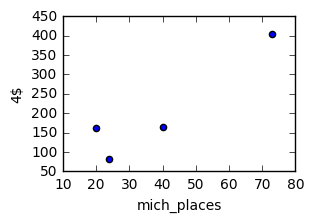

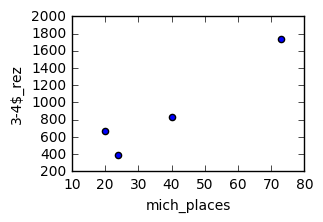

In [7]:
# is nice restaurant # a decent proxy for michelin restaurants?

# limit to one year of mich data
df_mich_oneyear = df_mich[(df_mich.year == 2015) | (df_mich.year == 2009)]

# combine dfs
df_mich_comb = pd.merge(df_mich_oneyear, df_nice_places, on='city')

print(df_mich_comb.plot(kind='scatter', x='mich_places', y='4$', figsize=(3,2)))
print(df_mich_comb.plot(kind='scatter', x='mich_places', y='3-4$_rez', figsize=(3,2)))

In [8]:
# simple regression

regr1 = np.polyfit(df_mich_comb['4$'].values, df_mich_comb['mich_places'].values, 1)
print(regr1)

regr2 = np.polyfit(df_mich_comb['3-4$_rez'].values, df_mich_comb['mich_places'].values, 1)
print(regr2)

[ 0.16099416  6.52793774]
[ 0.0395895   3.22355234]


In [9]:
# so mich restaurant ct = 6.53 + 0.16 * (number of 4$ places on yelp)
# or 3.22 + 0.04 * (number of 3-4$ places who take reservations)

# looking at washington d.c. yelp #s, there are 56 4$ places and 346 3-4$ w/ rez

DC_4 = 56
DC_3_4 = 346

print(regr1[1] + regr1[0] * DC_4)
print(regr2[1] + regr2[0] * DC_3_4)

15.5436104871
16.9215203501


In [10]:
# using summary stats of (mich restaurants / nice yelp places) factor

df_mich_comb['mich_factor_1'] = df_mich_comb['mich_places'] * 1.0 / df_mich_comb['4$']
df_mich_comb['mich_factor_2'] = df_mich_comb['mich_places'] * 1.0 / df_mich_comb['3-4$_rez']

f1 = df_mich_comb.mich_factor_1.describe().to_dict()
f2 = df_mich_comb.mich_factor_2.describe().to_dict()

# estimation of dc michelin restauarants (+- 1 std)

print((f1['mean'] - f1['std']) * DC_4, f1['mean'] * DC_4, (f1['mean'] + f1['std']) * DC_4)
print((f2['mean'] - f2['std']) * DC_3_4, f2['mean'] * DC_3_4, (f2['mean'] + f2['std']) * DC_3_4)

7.64777011697 11.7540875945 15.8604050719
11.1169565859 15.6502201852 20.1834837845


In [11]:
# ok, so we'll predict 7-20ish restaurants
# now, it's time to figure which DCs are michelin worthy...

In [12]:
# helper methods

def fetch(url):
    return BeautifulSoup(requests.get(url).content, "html.parser")

def get_yelp_biz_url(name):
    url = 'https://www.yelp.com/search?find_loc=Washington,+DC&find_desc={}'.format(quote(name))
    page = fetch(url)
    first_result = page.find('div', class_='natural-search-result')
    return 'https://www.yelp.com{}'.format(first_result.find('a', class_='biz-name').get('href'))

def get_yelp_biz_info(name):
    url = get_yelp_biz_url(name)
    page = fetch(url)
    
    name_official = page.find('h1').text.strip()
    cost = page.find('span', class_='price-range').text
    review_ct = page.find('span', class_='review-count').text.strip().split(' ')[0]
    
    monthly_ratings = json.loads(
        (page.find('div', id='rating-details-modal-content') or {}).get('data-monthly-ratings')   
    )

    score_hist = page.find('table', class_='histogram--large')
    score_rows = score_hist.findAll('tr', class_='histogram_row')
    score_distribution = [
        (r.find('th').text.strip().split(' ')[0], r.find('td', class_='histogram_count').text)
        for r in score_rows
    ]
    
    return {
        'name': name,
        'name_yelp': name_official,
        'cost': cost,
        'review_ct': review_ct,
        'monthly_ratings': monthly_ratings,
        'score_distribution': score_distribution, 
    }

In [15]:
# after gathering list of DC restaurants from various sources (see below),
# i created datasets of standardized names and summary info from yelp
# using helper methods above and stored as json (to avoid redundant html parsing)

# standardized restaurant names
with open('data-other/standardized-names.json') as f:
    name_lookup = json.loads(f.read())

# get (cached) restaurant details from yelp
with open('data-other/yelp-summary-details.json') as f:
    yelp_stats = json.loads(f.read())

In [16]:
# zagat top 25, done March 17, 2015

url = 'https://www.zagat.com/best-restaurants/washington-dc'
page = fetch(url)
restaurants = page.findAll('li', class_='card')

zagat = []
for r in restaurants:
    name = r.find('p', class_='title').text
    
    entry = {
        'rank': int(r.find('span', class_='count').text[1:]),
        'name': name_lookup.get(name) or name,
        'score_food': float(r.get('data-score-food')),
        'score_decor': float(r.get('data-score-decor')),
        'score_service': float(r.get('data-score-service')),
        'score_cost': float(r.get('data-score-cost')),
    }
    zagat.append(entry)

print('{} entries from zagat'.format(len(zagat)))
print('first entry: {}'.format(zagat[0]))

25 entries from zagat
first entry: {'name': 'Rasika', 'score_food': 4.811285, 'score_service': 4.514445, 'score_decor': 4.514445, 'score_cost': 52.2154, 'rank': 1}


In [17]:
# zagat df

df_zagat = pd.DataFrame.from_dict(zagat)
print(df_zagat.head())

                     name  rank  score_cost  score_decor  score_food  \
0                  Rasika     1     52.2154     4.514445    4.811285   
1                   Fiola     2     88.9189     4.714229    4.811285   
2                Corduroy     3     88.5555     4.514445    4.811285   
3  minibar by José Andrés     4    217.4545     4.714229    4.714229   
4           The Prime Rib     5     90.2857     4.514445    4.714229   

   score_service  
0       4.514445  
1       4.714229  
2       4.615307  
3       4.714229  
4       4.714229  


In [18]:
# washingtonian top 100, 2016, 02/08/2016, 3+ $'s

url = 'https://www.washingtonian.com/2016/02/08/100-very-best-restaurants/'
page = fetch(url)
restaurants = page.find('table', class_='very-best').find('tbody').findAll('tr')

washingtonian = []
for r in restaurants:
    info = r.findAll('td')
    
    rank = int(info[0].text)
    name = info[2].text
    cost = info[-1].text.split('-')[-1]
    
    if len(cost) < 3 or rank > 40:
        continue
    
    washingtonian.append({
        'rank': rank,
        'name': name_lookup.get(name) or name,
        'cost': cost,
    })

print('{} entries from washingtonian'.format(len(washingtonian)))
print('first entry: {}'.format(washingtonian[0]))

26 entries from washingtonian
first entry: {'name': 'Fiola Mare', 'cost': '$$$$', 'rank': 1}


In [19]:
# washingtonian df, top 25

df_washingtonian = pd.DataFrame.from_dict(washingtonian)
print(df_washingtonian.head())

   cost                          name  rank
0  $$$$                    Fiola Mare     1
1  $$$$                          Komi     2
2   $$$                  Little Serow     3
3  $$$$                         Plume     6
4  $$$$  The Inn at Little Washington     8


In [20]:
# tom sietsema (food critic) picks

tom_2014 = [
    [10, "Boss Shepherd's"],
    [9, 'Le Diplomate'],
    [8, 'The Partisan'],
    [7, 'Fiola Mare'],
    [6, 'Little Serow'],
    [5, 'Inn at Little Washington'],
    [4, 'Red Hen'],
    [3, "Rose's Luxury"],
    [2, 'Mintwood Place'],
    [1, 'Rasika'],
]

tom_2015 = [
    [10, 'The Grill Room'],
    [9, 'Komi'],
    [8, 'G by Mike Isabella'],
    [7, 'Garrison'],
    [6, 'The Riggsby'],
    [5, 'The Inn at Little Washington'],
    [4, 'Little Serow'],
    [3, 'Masseria'],
    [2, 'Rasika and Rasika West End'],
    [1, "Rose's Luxury"],
]

tom_2016 = [
    [10, 'Komi'],
    [9, 'Rasika'],
    [8, 'Little Serow'],
    [7, 'Inn at Little Washington'],
    [6, 'Minibar'],
    [5, 'Convivial'],
    [4, 'Kinship'],
    [3, 'Bad Saint'],
    [2, 'Pineapple and Pearls'],
]

tom_all = {
    2014: tom_2014,
    2015: tom_2015,
    2016: tom_2016,
}

for year, data in tom_all.items():
    for d in data:
        d[1] = name_lookup.get(d[1]) or d[1]

In [21]:
# tom df by year

df_tom_2014 = pd.DataFrame(tom_all[2014], columns=('rank_tom_14', 'name'))
df_tom_2015 = pd.DataFrame(tom_all[2015], columns=('rank_tom_15', 'name'))
df_tom_2016 = pd.DataFrame(tom_all[2016], columns=('rank_tom_16', 'name'))

# combine tom dfs

df_tom_all = pd.merge(df_tom_2014, df_tom_2015, how='outer', on='name')
df_tom_all = pd.merge(df_tom_all, df_tom_2016, how='outer', on='name')
print(df_tom_all)

    rank_tom_14                          name  rank_tom_15  rank_tom_16
0          10.0               Boss Shepherd’s          NaN          NaN
1           9.0                  Le Diplomate          NaN          NaN
2           8.0                  The Partisan          NaN          NaN
3           7.0                    Fiola Mare          NaN          NaN
4           6.0                  Little Serow          4.0          8.0
5           5.0  The Inn at Little Washington          5.0          7.0
6           4.0                   The Red Hen          NaN          NaN
7           3.0                 Rose’s Luxury          1.0          NaN
8           2.0                Mintwood Place          NaN          NaN
9           1.0                        Rasika          NaN          9.0
10          NaN                The Grill Room         10.0          NaN
11          NaN                          Komi          9.0         10.0
12          NaN            G By Mike Isabella          8.0      

In [22]:
# yelp, top 25 by rating, 3 & 4 $'s

lists = [
    ('$$$$', 'https://www.yelp.com/search?find_desc=Restaurants&find_loc=Washington,+DC&sortby=rating&attrs=RestaurantsPriceRange2.4&start='),
    ('$$$', 'https://www.yelp.com/search?find_desc=Restaurants&find_loc=Washington,+DC&sortby=rating&attrs=RestaurantsPriceRange2.3&start=')
]
num_pages = 3 # 10 per page

yelp = []
for li in lists:
    for i in range(num_pages):
        url = '{}{}'.format(li[1], i * 10)
        print('url: {}'.format(url))

        page = fetch(url)
        restaurants = page.findAll('div', class_='natural-search-result')

        for r in restaurants:
            rank = int(r.find('span', class_='indexed-biz-name').text.split('.')[0])
            name = r.find('a', class_='biz-name').text
            score = r.find('i', class_='star-img').get('title').split(' ')[0]
            review_ct = r.find('span', class_='review-count').text.strip().split(' ')[0]

            if rank > 25:
                continue
            
            yelp.append({
                'rank': rank,
                'name': name_lookup.get(name) or name,
                'cost': li[0],
                'score': score,
                'review_ct': review_ct,
            })

print('{} entries from yelp'.format(len(yelp)))
print('first entry: {}'.format(yelp[0]))

url: https://www.yelp.com/search?find_desc=Restaurants&find_loc=Washington,+DC&sortby=rating&attrs=RestaurantsPriceRange2.4&start=0
url: https://www.yelp.com/search?find_desc=Restaurants&find_loc=Washington,+DC&sortby=rating&attrs=RestaurantsPriceRange2.4&start=10
url: https://www.yelp.com/search?find_desc=Restaurants&find_loc=Washington,+DC&sortby=rating&attrs=RestaurantsPriceRange2.4&start=20
url: https://www.yelp.com/search?find_desc=Restaurants&find_loc=Washington,+DC&sortby=rating&attrs=RestaurantsPriceRange2.3&start=0
url: https://www.yelp.com/search?find_desc=Restaurants&find_loc=Washington,+DC&sortby=rating&attrs=RestaurantsPriceRange2.3&start=10
url: https://www.yelp.com/search?find_desc=Restaurants&find_loc=Washington,+DC&sortby=rating&attrs=RestaurantsPriceRange2.3&start=20
50 entries from yelp
first entry: {'review_ct': '644', 'name': 'Komi', 'cost': '$$$$', 'score': '4.5', 'rank': 1}


In [23]:
# yelp df

df_yelp = pd.DataFrame.from_dict(yelp)
df_yelp = df_yelp.rename(columns={'rank': 'rank_yelp'})
df_yelp = df_yelp[['name', 'rank_yelp']]

print(df_yelp.head())

                           name  rank_yelp
0                          Komi          1
1        minibar by José Andrés          2
2            Pineapple & Pearls          3
3  Marcel’s by Robert Wiedmaier          4
4             Makoto Restaurant          5


In [24]:
# combine top lists into one big (sparse) list

cols = ['name', 'rank']
df_ranks = pd.merge(df_zagat[cols], df_washingtonian[cols], how='outer', on='name', suffixes=('_zagat', '_dctonian'))
df_ranks = pd.merge(df_ranks, df_tom_all, how='outer', on='name')
df_ranks = pd.merge(df_ranks, df_yelp, how='outer', on='name')

print('{} total restaurants'.format(len(df_ranks)))
df_ranks.head()

74 total restaurants


,name,rank_zagat,rank_dctonian,rank_tom_14,rank_tom_15,rank_tom_16,rank_yelp
0,Rasika,1.0,NaN,1.0,NaN,9.0,4.0
1,Fiola,2.0,23.0,NaN,NaN,NaN,11.0
2,Corduroy,3.0,NaN,NaN,NaN,NaN,10.0
3,minibar by José Andrés,4.0,22.0,NaN,NaN,6.0,2.0
4,The Prime Rib,5.0,NaN,NaN,NaN,NaN,21.0


In [25]:
# after combining top lists from zagat, washingtonian, tom, and yelp,
# we have 74 distinct restaurants - a good starting point!

In [26]:
# let's add a few more columns with this new, combined dataset:
# 1) number of mentions across all sources
# 2) number of top-3s across all sources 

rank_cols = [
    'rank_zagat', 'rank_dctonian', 'rank_yelp',
    'rank_tom_14', 'rank_tom_15', 'rank_tom_16'
]

df_ranks2 = df_ranks.copy()

df_ranks2['mentions'] = df_ranks2.apply(lambda r: sum(r[rank_cols].notnull().values), axis=1)
df_ranks2['mentions_top_3'] = df_ranks2.apply(lambda r: sum((r[rank_cols] <= 3).values), axis=1)

df_ranks2.head()

,name,rank_zagat,rank_dctonian,rank_tom_14,rank_tom_15,rank_tom_16,rank_yelp,mentions,mentions_top_3
0,Rasika,1.0,NaN,1.0,NaN,9.0,4.0,4,2
1,Fiola,2.0,23.0,NaN,NaN,NaN,11.0,3,1
2,Corduroy,3.0,NaN,NaN,NaN,NaN,10.0,2,1
3,minibar by José Andrés,4.0,22.0,NaN,NaN,6.0,2.0,4,1
4,The Prime Rib,5.0,NaN,NaN,NaN,NaN,21.0,2,0


In [27]:
# let's clean up the yelp summary data

yelp_stats_clean = []
for key, data in yelp_stats.items():
    review_ct = int(data['review_ct'])
    score_hist = {int(s[0]): int(s[1]) for s in data['score_distribution']}
    score_last_month = float(data['monthly_ratings']['2016'][-1][1])
    
    entry = {
        'name': data['name_yelp'],
        'y_cost': len(data['cost']),
        'y_ct': review_ct,
        'y_score_lastmo': score_last_month,
        'y_perc_5': score_hist[5] * 1.0 / review_ct,
        'y_perc_4_5': (score_hist[4] + score_hist[5]) * 1.0 / review_ct,
    }
    yelp_stats_clean.append(entry)

df_yelp_stats = pd.DataFrame.from_dict(yelp_stats_clean)
df_yelp_stats.head()

,name,y_cost,y_ct,y_perc_4_5,y_perc_5,y_score_lastmo
0,Fogo de Chão Brazilian Steakhouse,3,1393,0.832735,0.530510,3.8
1,Filomena Ristorante,3,1526,0.771298,0.467235,4.6
2,Siroc Restaurant,3,388,0.793814,0.376289,4.3
3,Charlie Palmer Steak,4,374,0.663102,0.385027,3.5
4,The Dabney,3,170,0.764706,0.547059,4.2


In [28]:
# combine rank data with yelp stats

df_all = pd.merge(df_ranks2, df_yelp_stats, on='name')

df_all.iloc[0]

name                Rasika
rank_zagat               1
rank_dctonian          NaN
rank_tom_14              1
rank_tom_15            NaN
rank_tom_16              9
rank_yelp                4
mentions                 4
mentions_top_3           2
y_cost                   3
y_ct                  2232
y_perc_4_5        0.825717
y_perc_5          0.577061
y_score_lastmo           4
Name: 0, dtype: object

In [29]:
# keep only relevant columns

cols = [
    'name', 'mentions', 'mentions_top_3',
    'y_cost', 'y_ct', 'y_score_lastmo', 'y_perc_4_5', 'y_perc_5',
]
df_all = df_all[cols]

df_all.head()

,name,mentions,mentions_top_3,y_cost,y_ct,y_score_lastmo,y_perc_4_5,y_perc_5
0,Rasika,4,2,3,2232,4.0,0.825717,0.577061
1,Fiola,3,1,4,480,4.6,0.760417,0.497917
2,Corduroy,2,1,3,481,4.9,0.835759,0.523909
3,minibar by José Andrés,4,1,4,253,4.5,0.830040,0.695652
4,The Prime Rib,2,0,4,291,3.9,0.656357,0.367698


In [30]:
# numeric column summaries

df_all.describe()

,mentions,mentions_top_3,y_cost,y_ct,y_score_lastmo,y_perc_4_5,y_perc_5
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,1.767123,0.273973,3.287671,525.424658,4.101998,0.754145,0.480448
std,1.148919,0.606911,0.588771,535.289950,0.414011,0.085021,0.130664
min,1.000000,0.000000,2.000000,55.000000,2.800000,0.564103,0.214470
25%,1.000000,0.000000,3.000000,204.000000,3.900000,0.696970,0.385027
50%,1.000000,0.000000,3.000000,375.000000,4.100000,0.771298,0.488722
75%,2.000000,0.000000,4.000000,574.000000,4.400000,0.818182,0.571831
max,6.000000,3.000000,4.000000,3312.000000,4.900000,0.917127,0.740864


In [32]:
# ok, now let's filter down our list based on reasonable assumptions

df_all2 = df_all.copy()

# minimums
MENTIONS = 2
YELP_REVIEWS = 50
COST = 3  # max of 4
LASTMO_RATING = 3.9  # max of 5
PERCENT_4_OR_5 = .74
PERCENT_5 = .49

# mentioned in at least n top lists
df_all2 = df_all2[df_all2.mentions >= MENTIONS]
print(len(df_all2))

# at least n yelp reviews
df_all2 = df_all2[df_all2.y_ct >= YELP_REVIEWS]
print(len(df_all2))

# at least n$s
df_all2 = df_all2[df_all2.y_cost >= COST]
print(len(df_all2))

# yelp score last month
df_all2 = df_all2[df_all2.y_score_lastmo >= LASTMO_RATING]
print(len(df_all2))

# percent of 4/5s on yelp
df_all2 = df_all2[df_all2.y_perc_4_5 > PERCENT_4_OR_5]
print(len(df_all2))

# percent of 5s on yelp
df_all2 = df_all2[df_all2.y_perc_5 > PERCENT_5]
print(len(df_all2))

31
31
31
24
20
15


In [33]:
df_all2

,name,mentions,mentions_top_3,y_cost,y_ct,y_score_lastmo,y_perc_4_5,y_perc_5
0,Rasika,4,2,3,2232,4.0,0.825717,0.577061
1,Fiola,3,1,4,480,4.6,0.760417,0.497917
2,Corduroy,2,1,3,481,4.9,0.835759,0.523909
3,minibar by José Andrés,4,1,4,253,4.5,0.830040,0.695652
5,The Red Hen,3,0,3,449,4.6,0.779510,0.496659
9,Marcel’s by Robert Wiedmaier,3,0,4,375,4.1,0.802667,0.592000
10,Rose’s Luxury,5,3,3,1230,4.5,0.864228,0.700813
18,Blue Duck Tavern,3,0,3,1577,4.6,0.807863,0.512365
20,Komi,5,2,4,644,4.1,0.877329,0.712733
21,Fiola Mare,4,1,3,574,3.9,0.822300,0.602787


In [34]:
# remove any bib gourmand restaurants

bg = ['The Red Hen']
df_all2 = df_all2[~df_all2.name.isin(bg)]

In [35]:
# to faciliate adding metrics together / creating total score,
# let's compute z-scores to normalize metrics

# add get summary stats of relevant cols

df_z = df_all2.copy()
cols = ['mentions_top_3', 'y_score_lastmo', 'y_perc_4_5', 'y_perc_5']

# get summary stats
df_z_ss = df_z[cols].describe()

# limit to count, mean, and standard deviation
df_z_ss = df_z_ss.loc['count':'std']

# convert to json
stats = json.loads(df_z_ss.to_json())

# add normalized z-score for each col
for c in cols:
    df_z['{}_z'.format(c)] = df_z[c].apply(
        lambda x: 0 if pd.isnull(x) else ((x - stats[c]['mean']) / stats[c]['std'])
    )
    
# combine z-scores into 1 score
cols_z = ['{}_z'.format(c) for c in cols]
df_z['score'] = df_z[cols_z].sum(axis=1)

# add fanciness weight (i.e., rewarding higher prices)
boost = df_z.score.std() * 1.25
df_z['fanciness'] = df_z.y_cost.apply(lambda x: boost if x == 4 else 0)
df_z['score'] = df_z.score + df_z.fanciness

# sort by score
df_z.sort_values(by='score', ascending=False, inplace=True)

# filter cols
cols = [
    'name', 'y_cost', 'mentions', 'mentions_top_3',
    'y_score_lastmo', 'y_perc_4_5', 'y_perc_5', 'score'
]
df_z = df_z[cols]

print(len(df_z))
df_z

14


,name,y_cost,mentions,mentions_top_3,y_score_lastmo,y_perc_4_5,y_perc_5,score
47,Pineapple & Pearls,4,2,2,4.6,0.913580,0.703704,9.256439
20,Komi,4,5,2,4.1,0.877329,0.712733,7.059224
3,minibar by José Andrés,4,4,1,4.5,0.830040,0.695652,6.106594
10,Rose’s Luxury,3,5,3,4.5,0.864228,0.700813,5.120683
1,Fiola,4,3,1,4.6,0.760417,0.497917,2.459529
9,Marcel’s by Robert Wiedmaier,4,3,0,4.1,0.802667,0.592000,1.907725
36,Obelisk,4,2,0,4.3,0.774194,0.574194,1.734454
2,Corduroy,3,2,1,4.9,0.835759,0.523909,1.441794
45,Kinship,4,2,0,4.0,0.764151,0.556604,0.355402
0,Rasika,3,4,2,4.0,0.825717,0.577061,0.120632


In [36]:
# ok, now we have a filtered down & sorted list of best places, it's time to allocate the stars
# ~21% of michelin restaurants are 2 or 3 stars (in cities looked at above)
# let's assume in first year, dc has no three star places
# so .21 * 14 = ~3 two stars restaurants

final_list = [
    [n, 2 if i < 3 else 1] for i, n in enumerate(df_z.name.values)
]

df_final = pd.DataFrame(final_list, columns=('restaurant', 'stars'))
print(df_final)

                      restaurant  stars
0             Pineapple & Pearls      2
1                           Komi      2
2         minibar by José Andrés      2
3                  Rose’s Luxury      1
4                          Fiola      1
5   Marcel’s by Robert Wiedmaier      1
6                        Obelisk      1
7                       Corduroy      1
8                        Kinship      1
9                         Rasika      1
10                         Plume      1
11                    Fiola Mare      1
12              Blue Duck Tavern      1
13                  Little Serow      1


In [37]:
# output final results

df_final.to_csv('brendansudol-submission.csv', index=False)